## CISB63 NLP


Professor: Angel Hernandez<br>
Student: Jack Chen<br>
<br>
Topic: Stock Prices vs Tweet Sentiment <br>
    NLP - nltk, spacy, wordcloud<br>
    DL - LSTM, Conv1D w/ Bidirectional, GRU <br>
1. Parsing - alpha_vantage, tweepy; <br>
2. Data cleaning, EDA, NLP, Preprocessing, Sentiment Analysis, Load Model <br>
3. Save transformer to pickle, model checkpoint, tensorboard<br>
4. Conclusion<br>
5. References<br>


## Import


In [1]:
# Parsing
import tweepy
from tweepy import Stream
from tweepy import OAuthHandler
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.fundamentaldata import FundamentalData
from alpha_vantage.cryptocurrencies import CryptoCurrencies
from alpha_vantage.techindicators import TechIndicators


# Data processing
import pandas as pd
import numpy as np


# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
sns.set_theme(style="whitegrid") # all charts will have a light grid
# from wordcloud import WordCloud, STOPWORDS
from nltk.probability import FreqDist
import spacy
from spacy import displacy


# Text Preprocessing/cleaning
import re
import string
import nltk
from nltk.corpus import stopwords 
# nltk.download('stopwords')
# nltk.download('words')
words = set(nltk.corpus.words.words())
from nltk.stem.porter import * 
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Text valuation/detection
import langid
from googletrans import Translator
from nltk.sentiment import SentimentIntensityAnalyzer as SIA
# nltk.downloader.download('vader_lexicon')


# Misc
import pickle
from keras.models import load_model
import os
import glob
import warnings
warnings.filterwarnings("ignore")



## Functions

In [2]:
# determine text sentiment using TextBlob
def siaSent(x):
    a = SIA()
    a = a.polarity_scores(str(x))['compound']

    if a > 0:
        return 'Positive'
    elif a == 0:
        return 'Neutral'
    else:
        return 'Negative'

# convert lower case, remove non letters, split to list, remove stop words, stem words
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    tx = ' '.join(tweet)
    # convert to lowercase
    text = tx.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()

    wds=stopwords.words("english")
    wds.remove('not')
    # remove stopwords
    words = [w for w in words if w not in wds]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

# remove url
def remove_url(txt):
    return " ".join(re.sub("([-a-zA-Z0-9@:%_\+.~#?&//=]{2,256}\.[a-z]{2,4}\b(\/[-a-zA-Z0-9@:%_\+.~#?&//=]*)?)", "", txt).split())
#remove hashtag #
def remove_hashtag(txt):
    return " ".join(re.sub("([#]+)([0-9A-Z_]*[A-Z_]+[a-z0-9_üÀ-ÖØ-öø-ÿ]*)", "", txt).split())
# remove mention @
def remove_at(txt):
    return " ".join(re.sub("(\@[a-zA-Z0-9_%]*)", "", txt).split())

# remove stopwords and puncturations
def get_text_processing(text):
    stpword = stopwords.words('english')
    stpword.remove('not')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])



# remove #, @, url, stopwords, punctuations, stemming
def removeFunc(a):
    x = remove_at(a)
    x = remove_hashtag(x)
    x = remove_url(x)
    x= get_text_processing(x.lower())
    return x
    
# Check if each word is english word
def engOnly(x):
    a = " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words ) #or not w.isalpha()
    return a

# Remove names from text
def removeName(x):
    names = ['twtr', 'twitter', 'rt','elon','musk']
    new_text = []
    for a in x:
        if a.lower() not in names:
            new_text.append(a.lower())
    return new_text
    
# detect language - Note: may not be most accurate
def lanDetectFunc(x):
    a = langid.classify(x)
    return a[0]

# function detect bot
def botDetect(x):
    if 'bot' in x:
        return True
        
# only get dates
def convTime(x):
    x = x[:10]
    return x

def predictFunc(x):
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    try:
        # since x is cleaned, we tokenize right away
        a = token.texts_to_sequences(x)

        # apply padding
        a_pad = pad_sequences(a, maxlen = 16, padding='post')

        # predict
        y = model.predict(a_pad).argmax(axis=1)
        a = sentiment_classes[y[0]]
    except:
        a = 'NoWork'
    return a

######################### API Keys #########################
# Load key for tweepy
path = r'C:\Users\Gumo\Desktop\Git\Notebook\keys\tweepy.txt'
keys = []
with open(path, mode='r') as w:
    for line in w:
        keys.append(line.split(': ')[1].strip())
access_token = keys[3]
access_secret = keys[4]
consumer_key = keys[0]
consumer_secret = keys[1]
bearer_token = keys[2]

###### my id/name #####
myUserId = 1309643764172947456
myUsername = 'stockjanitor'

# Load Twitter API
# Twitter API v1 - auth keys (Cursor)
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token,access_secret)

# create instance
twitterApi = tweepy.API(auth, wait_on_rate_limit=True)
# wait on rate limit, not to get errors on timing out

# verify credential
try:
    # see if credential works
    twitterApi.verify_credentials()
    print("twitterApi works")
except:
    print("Please fix me")

# Variable - store Alpha Vantage API key
path =  r'C:\Users\Gumo\Desktop\Git\Notebook\keys\alphaVantage.txt'
with open(path, mode='r') as w:
    alphaKey = (w.readline())

################################################## API Functions ##################################################
###### Twitter FUNCTIONS ######
def tweetPost(text):
    try:
        twitterApi.update_status(text)
        print("bling bling~~")
    except:
        print("boom boom")
def tweetMedia(text, img):
    try:
        media = twitterApi.media_upload(img)
        twitterApi.update_status(text,media_ids=[media.media_id_string])
        print("bling bling~~")
    except:
        print("boom boom")
def tweetFriend(name):
    try:
        twitterApi.create_friendship(screen_name=name)
        print("bling bling~~")
    except:
        print("boom boom")
def tweetUnfriend(name):
    try:
        twitterApi.destroy_friendship(screen_name=name)
        print("bling bling~~")
    except:
        print("boom boom")

# Function AlphaVantage
def alpha(key, symbol, function, period=None, typ = None, tim=None, outputsize = 'compact'):
    
    # Funciton - TimeSeries
    if function == 't':
        # Instance - TimeSeries Instance
        ts = TimeSeries(key = key, output_format='pandas')
        if period == 'd':
            data = ts.get_daily(symbol, outputsize=outputsize)[0]
        elif period == 'w':
            data = ts.get_weekly_adjusted(symbol)[0]
        elif period == 'm':
            data = ts.get_monthly_adjusted(symbol)[0]

    # Funciton - FundamentalData
    elif function == 'f':
        # Instance - FundamentalData Instance
        fd = FundamentalData(key, output_format='pandas')
        if period == 'q':
            if typ == 'i':
                data = fd.get_income_statement_quarterly(symbol)[0]
                data.index = data.iloc[:,0]
                data=data.iloc[:,2:]
            elif typ == 'b':
                data = fd.get_balance_sheet_quarterly(symbol)[0]
                data.index = data.iloc[:,0]
                data=data.iloc[:,2:]
            elif typ=='c':
                data = fd.get_cash_flow_quarterly(symbol)[0]
                data.index = data.iloc[:,0]
                data=data.iloc[:,2:]
        elif period =='a':
            if typ == 'i':
                data = fd.get_income_statement_annual(symbol)[0]
                data.index = data.iloc[:,0]
                data=data.iloc[:,2:]
            elif typ == 'b':
                data = fd.get_balance_sheet_annual(symbol)[0]
                data.index = data.iloc[:,0]
                data=data.iloc[:,2:]
            elif typ=='c':
                data = fd.get_cash_flow_annual(symbol)[0]
                data.index = data.iloc[:,0]
                data=data.iloc[:,2:]
    
    # Funciton - TechnicalIndicator            
    elif function =='ti':
        ti = TechIndicators(key,output_format='pandas')

        # reassign period into TI format
        if period == 'm':
            period = 'monthly'
        elif period =='w':
            period = 'weekly'
        elif period == 'd':
            period ='daily'

        if typ == 'rsi':
            data=ti.get_rsi(symbol,interval=period,time_period=tim,series_type='close')[0]
        elif typ =='so':
            data = ti.get_stoch(symbol,interval=period)[0]
            
    # Funciton - CC
    elif function == 'c':
        # Instance - Crypto
        cc = CryptoCurrencies(key, output_format='pandas')
        pass
    return data

twitterApi works


## Parsing

In [42]:
# Tweepy Parsing
query1 = "#twtr"
hour = '01'

date = '20220530'
time =hour+'00'
time2='2359'
fromdate =date+time
todate=date+time2

######################## Search 30 Day Queries ########################
# store search in tweets
queryResponse1 = twitterApi.search_30_day(label='30Days',query=query1,fromDate=fromdate,toDate=todate,maxResults=100)
# save tweets to list1
list1 = [[tweet.user.screen_name,tweet.text,tweet.created_at,tweet.user.location,tweet.source,tweet.favorite_count,tweet.quote_count,tweet.reply_count,tweet.retweet_count]for tweet in queryResponse1]
# convert tweet list into dataframe
df = pd.DataFrame(data=list1,columns=['user','text','time','location','source','like_count','quote_count','reply_count','retweet_count'])
# save to dataframe
df.to_csv('data_tweets/'+date+time+time2+query1+'.csv')
df.shape



######################## Search Recent queries ########################
# sincedate=''
# queryResponse1 = twitterApi.search_tweets(q=query1,until=sincedate,count=100)
# # items = 5, retrieve 5 tweets
# list1 = [[tweet.user.screen_name,tweet.text,tweet.created_at,tweet.user.location,tweet.source,tweet.favorite_count,tweet.retweet_count]for tweet in queryResponse1]
# # convert tweet list into dataframe
# df = pd.DataFrame(data=list1,columns=['user','text','time','location','source','like_count','retweet_count'])
# # save to dataframe
# df.to_csv('data/'+sincedate+query1+'.csv')
# df.shape

(54, 9)

In [52]:
# Alpha Vantage Parsing
# Variable Size (compact or full)
outputsize = 'compact'

# Variable Stock
symbol = 'twtr'

# Variable Function - t, f, c, ti (timeseries, financialdata, crypto, technical indicator)
function = 't'

# Variable Period
# TimeSeries: d,w,m,i (daily, weekly, monthly, interval(mins))
# Fundamental: q,a (quarterly,annually)
# Technical: d,w,m, (interval(mins))
period = 'd'

# Varible - Type
# Fundamental: i,b,c (income statement, balance sheet, cashflow)
# Technical: so,rsi
typ ='so'

# Varible - Time
tim = 60

info = alpha(alphaKey,symbol,function,period=period,typ = typ,tim=tim, outputsize='full')
info.head()



,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2022-05-31,40.07,40.3500,39.42,39.60,11154668.0
2022-05-27,39.57,40.7700,39.48,40.17,16789855.0
2022-05-26,38.52,39.5899,38.23,39.52,22968398.0
2022-05-25,36.06,37.3700,36.02,37.16,23262766.0
2022-05-24,36.94,37.2026,35.40,35.76,22662972.0


In [55]:
# save to local stock data
info.to_csv('data_stock/'+symbol.upper()+'stockPrice.csv')

In [56]:
info.tail()

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2013-11-13,41.03,42.87,40.760,42.60,8688300.0
2013-11-12,43.66,43.78,41.830,41.90,6316700.0
2013-11-11,40.50,43.00,39.400,42.90,16113900.0
2013-11-08,45.93,46.94,40.685,41.65,27925300.0
2013-11-07,45.10,50.09,44.000,44.90,117701600.0


## Load/Clean Data

In [7]:
pathOfData = 'data_tweets/' 
# saves path all file name to variable all_files
all_files2 = glob.glob(os.path.join(pathOfData , "*.csv"))
#initiate a list
merged_list2 = []

# loop all files to append each file to list
for b in all_files2:
    df = pd.read_csv(b, index_col=0, header=0)
    merged_list2.append(df)

# concat all files
merged_df2 = pd.concat(merged_list2, axis=0, ignore_index=True)
merged_df2.shape

(2385, 9)

In [8]:
merged_df2.head(3)

,user,text,time,location,source,like_count,quote_count,reply_count,retweet_count
0,topstonks,$TWTR was the 8th most mentioned on wallstreet...,2022-05-01 23:17:26+00:00,NaN,topstonks,0,0,0,0
1,Samxxgold,New investors trying to understand the Stock M...,2022-05-01 23:11:23+00:00,"St Paul, MN",Twitter for iPhone,0,0,0,0
2,Ralphtan222,(要人の声明があった様)\n\nvia @Forbes \n#news #TWTR #Elo...,2022-05-01 23:01:45+00:00,DeCenterized Tokyo🗼⇄NY🗽,Twitter for iPhone,0,0,1,0


In [9]:
master_df = merged_df2
# convert to string
master_df['bot'] = master_df['source'].apply(lambda x: botDetect(x.lower()))
master_df.head()

,user,text,time,location,source,like_count,quote_count,reply_count,retweet_count,bot
0,topstonks,$TWTR was the 8th most mentioned on wallstreet...,2022-05-01 23:17:26+00:00,NaN,topstonks,0,0,0,0,None
1,Samxxgold,New investors trying to understand the Stock M...,2022-05-01 23:11:23+00:00,"St Paul, MN",Twitter for iPhone,0,0,0,0,None
2,Ralphtan222,(要人の声明があった様)\n\nvia @Forbes \n#news #TWTR #Elo...,2022-05-01 23:01:45+00:00,DeCenterized Tokyo🗼⇄NY🗽,Twitter for iPhone,0,0,1,0,None
3,ScottGraffius,RT @ScottGraffius: The lifespan (half-life) 🕟 ...,2022-05-01 20:44:02+00:00,California,Twitter Web App,0,0,0,0,None
4,Idacrypto1,Who else is going long on #TWTR #ElonMusk #Bul...,2022-05-01 20:09:10+00:00,NaN,Twitter for Android,0,0,0,0,None


In [10]:
# count num of bots
master_df.bot.value_counts()

True    47
Name: bot, dtype: int64

In [11]:
# save to df, drop bot, drop bot column, reset index
master_df1 = master_df[master_df['bot'] != True].iloc[:,0:-1].reset_index(drop=True)
master_df1.columns

Index(['user', 'text', 'time', 'location', 'source', 'like_count',
       'quote_count', 'reply_count', 'retweet_count'],
      dtype='object')

In [12]:
master_df2 = master_df1.iloc[:,1:]
master_df2.columns

Index(['text', 'time', 'location', 'source', 'like_count', 'quote_count',
       'reply_count', 'retweet_count'],
      dtype='object')

In [13]:
# assign new df
master_df3 = master_df2

# df2 has time converted convert time
master_df3['time'] = master_df2['time'].apply(lambda x: convTime(x))
master_df3.head()

,text,time,location,source,like_count,quote_count,reply_count,retweet_count
0,$TWTR was the 8th most mentioned on wallstreet...,2022-05-01,NaN,topstonks,0,0,0,0
1,New investors trying to understand the Stock M...,2022-05-01,"St Paul, MN",Twitter for iPhone,0,0,0,0
2,(要人の声明があった様)\n\nvia @Forbes \n#news #TWTR #Elo...,2022-05-01,DeCenterized Tokyo🗼⇄NY🗽,Twitter for iPhone,0,0,1,0
3,RT @ScottGraffius: The lifespan (half-life) 🕟 ...,2022-05-01,California,Twitter Web App,0,0,0,0
4,Who else is going long on #TWTR #ElonMusk #Bul...,2022-05-01,NaN,Twitter for Android,0,0,0,0


In [14]:
# converting source to prepare piechart
sourceCount_df = pd.DataFrame(master_df3.source.value_counts()).reset_index()
sourceCount_df.rename(columns={"index": "sourcename"}, inplace=True)
# store sourcename
sourcelist= list(sourceCount_df.sourcename.head(6))
# convert source names
def sourceConv(x):
    if x in sourcelist:
        return str(x)
    else:
        return 'Others'

sourceCount_df["sourcename2"] = sourceCount_df['sourcename'].apply(lambda x: sourceConv(x))

#groupby new srouce name, reset index
sourceCount_df = sourceCount_df.groupby('sourcename2').sum().reset_index()
# calculate percent
sourceCount_df["percent"] = sourceCount_df['source'].apply(lambda x: x/sourceCount_df['source'].sum())
sourceCount_df = sourceCount_df.sort_values(by=['source'])
sourceCount_df

,sourcename2,source,percent
4,Twitter for iPad,23,0.009837
6,topstonks,38,0.016253
0,LinkedIn,43,0.018392
1,Others,165,0.070573
3,Twitter for Android,343,0.146707
5,Twitter for iPhone,709,0.303251
2,Twitter Web App,1017,0.434987


Text(0.5, 1.0, 'Sources')

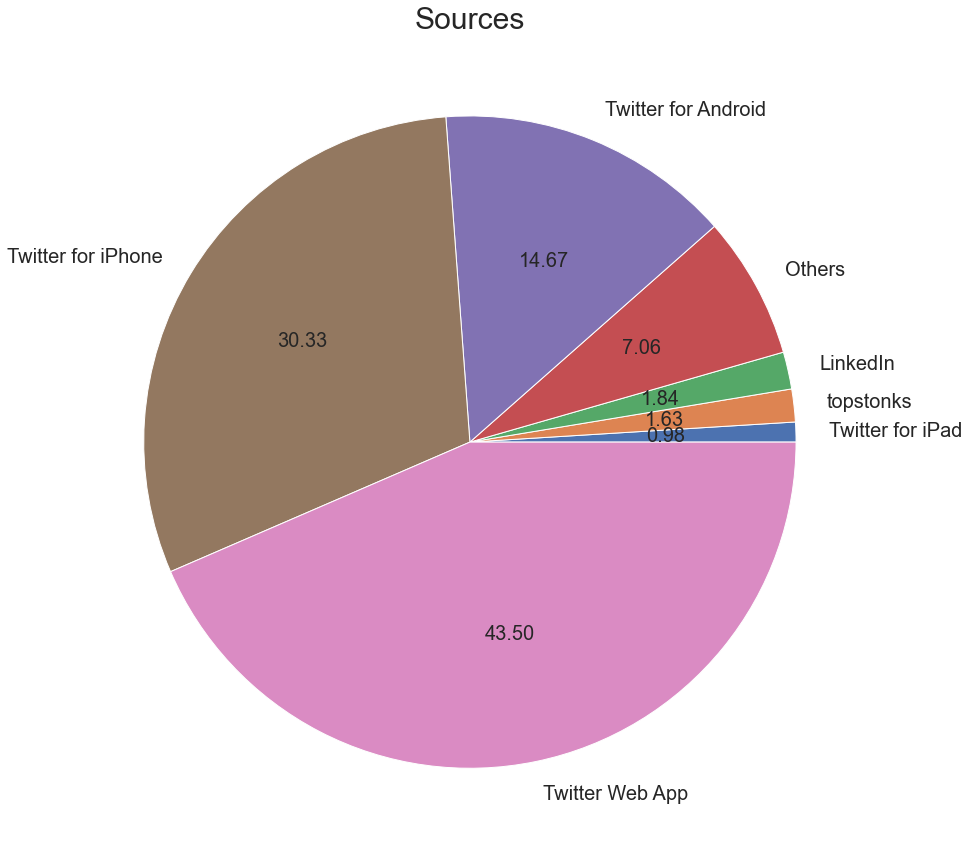

In [15]:

mpl.rcParams['font.size'] = 25
# plot chart
plt.figure(figsize=(15,15))
# realize dont need percent, pie chat calculates for you
plt.pie(sourceCount_df.source, labels=sourceCount_df.sourcename2, autopct='%.2f',textprops= {"fontsize":20})
plt.title('Sources', fontsize=30)

In [82]:
# # recently had huge retweet, i wanted to see what the message was
# retweet_df = master_df3.sort_values(by='retweet_count',ascending=False)
# retweet_df.head()

In [16]:
master_df4 = master_df3
# detect language
master_df4['lang'] = master_df3.text.apply(lambda x :lanDetectFunc(x))
master_df4.head()
# master_df3['translateText'] = master_df3['text'].apply(translator1.translate, dest='en').apply(getattr, args=('text',))

,text,time,location,source,like_count,quote_count,reply_count,retweet_count,lang
0,$TWTR was the 8th most mentioned on wallstreet...,2022-05-01,NaN,topstonks,0,0,0,0,en
1,New investors trying to understand the Stock M...,2022-05-01,"St Paul, MN",Twitter for iPhone,0,0,0,0,en
2,(要人の声明があった様)\n\nvia @Forbes \n#news #TWTR #Elo...,2022-05-01,DeCenterized Tokyo🗼⇄NY🗽,Twitter for iPhone,0,0,1,0,ja
3,RT @ScottGraffius: The lifespan (half-life) 🕟 ...,2022-05-01,California,Twitter Web App,0,0,0,0,en
4,Who else is going long on #TWTR #ElonMusk #Bul...,2022-05-01,NaN,Twitter for Android,0,0,0,0,en


In [17]:
master_df4.lang.value_counts().head()

en    1697
ar     143
tr      55
es      54
ja      50
Name: lang, dtype: int64

In [158]:
# give each tweet a count of 1
master_df4['tweet_count'] = 1
master_df4.head(3)

,text,time,location,source,like_count,quote_count,reply_count,retweet_count,lang,tweet_count
0,$TWTR was the 8th most mentioned on wallstreet...,2022-05-01,NaN,topstonks,0,0,0,0,en,1
1,New investors trying to understand the Stock M...,2022-05-01,"St Paul, MN",Twitter for iPhone,0,0,0,0,en,1
2,(要人の声明があった様)\n\nvia @Forbes \n#news #TWTR #Elo...,2022-05-01,DeCenterized Tokyo🗼⇄NY🗽,Twitter for iPhone,0,0,1,0,ja,1


In [161]:
# count the tweets, retweet, likes
count_df = master_df4[['time','retweet_count','like_count','tweet_count']].groupby('time').sum().reset_index()

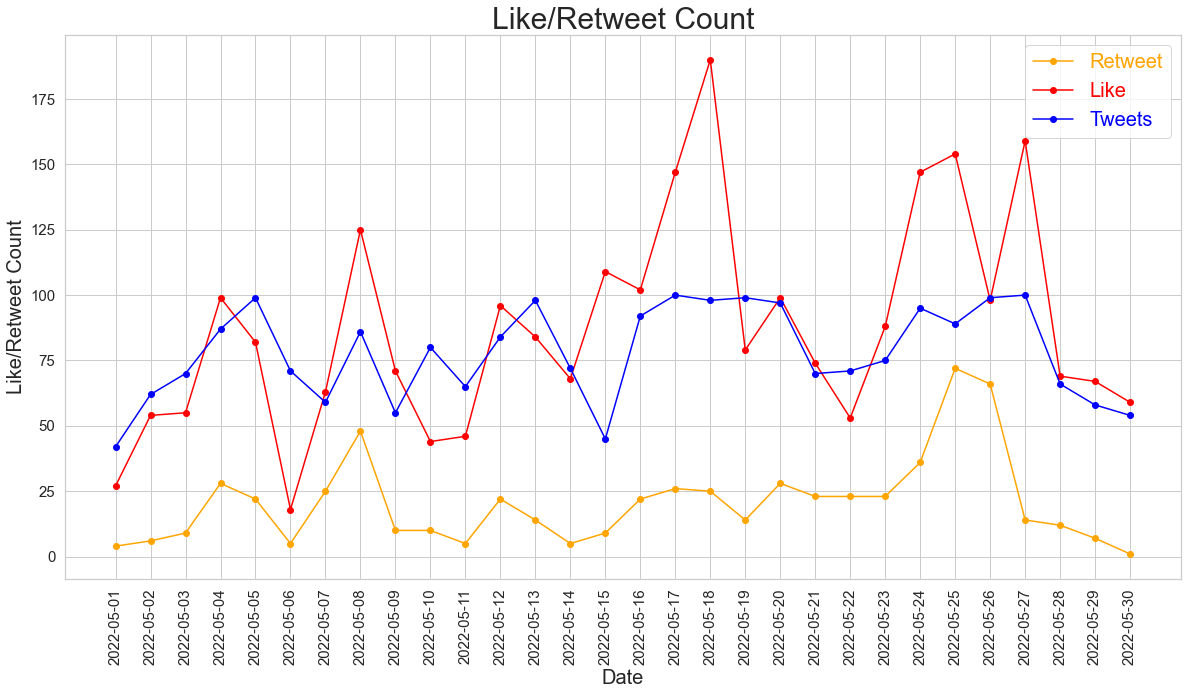

In [162]:
#plot
#figsize
plt.figure(figsize=(20,10))
#plot, label and color
plt.plot(count_df.time, count_df.retweet_count, 'o-', label="Retweet", color='orange')
plt.plot(count_df.time, count_df.like_count, 'o-', label="Like", color='red')
plt.plot(count_df.time, count_df.tweet_count, 'o-', label="Tweets", color='blue')


plt.xlabel('Date', fontsize=20)
plt.ylabel('Like/Retweet Count', fontsize = 20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15,rotation=90)
plt.title('Like/Retweet Count', fontsize=30)
plt.legend(labels=['Retweet','Like','Tweets'],labelcolor=['orange','red','blue'],loc="upper right", prop={'size': 20})

In [93]:
# recently had huge retweet, i wanted to see what the message was
df3 = master_df4.sort_values(by='retweet_count',ascending=False)

#top 1 2 3 assign to a b c
a = df3.iloc[0,0]
b = df3.iloc[1,0]
c = df3.iloc[2,0]
print(f'1. {a}\n2. {b}\n3. {c}')

1. خيااااااااااااااااال هذا من فضل ربي
#رادار_السوق جراءة قوة دقة ثروة #الخير_مقبل #OptionsTrading #tsla $tsla #spx… https://t.co/ulg0791hZO
2. #twtr $twtr
#رادار_السوق 
#الخير_مقبل 
مبرووووووووووووك هذا من فضل ربي
اللي متابعين معنا https://t.co/0k0b2p2ZdN
3. Ne avız ne avcıyız, sadece yatırımcıyız 
#GLCVY 
#tsla #aapl #nvda #twtr #msft #amzn #amd #googl #fb #wfc #sapg… https://t.co/LnHSBdIcrm


In [92]:
# check top 3 in df see its other info
df3.iloc[0:3,:]


,text,time,location,source,like_count,quote_count,reply_count,retweet_count,lang
2047,خيااااااااااااااااال هذا من فضل ربي\r\n#رادار_...,2022-05-26,Saudia-Jeddah,Twitter Web App,70,1,21,63,ar
1917,#twtr $twtr\n#رادار_السوق \n#الخير_مقبل \nمبرو...,2022-05-25,Saudia-Jeddah,Twitter Web App,57,0,11,56,ar
462,"Ne avız ne avcıyız, sadece yatırımcıyız \r\n#G...",2022-05-07,NaN,Twitter for Android,29,0,0,19,tr


In [ ]:
# initialize google Translator
translator = Translator()

In [87]:
# use google translate to detect language
bb= translator.detect(b)
bb.lang

'ar'

In [86]:
# use google translate to detect language
cc= translator.detect(c)
cc.lang

'tr'

In [88]:
# use google translate to translate language from src to dest
aa = translator.translate(a,src='ar',dest='en')
bb = translator.translate(b,src='ar',dest='en')
cc = translator.translate(c,src='tr',dest='en')

In [90]:
print(f'1. {aa.text}\n2. {bb.text}\n3. {cc.text}')

1. Wow, this is by the grace of my Lord
#Market_Radar, Audacity, Strength, Accuracy, Wealth
2. #twtr $twtr
#marketradar
#good_before
Congratulations, this is by the grace of God
Those who follow us https://t.co/0k0b2p2ZdN
3. We are neither hunters nor prey, we are just investors.
#GLCVY
#tsla #aapl #nvda #twtr #msft #amzn #amd #googl #fb #wfc #sapg… https://t.co/LnHSBdIcrm


In [38]:
# make new df, select only en
master_df5 = master_df4[master_df4.lang =='en']
master_df5.head(2)

,text,time,location,source,like_count,quote_count,reply_count,retweet_count,lang
0,$TWTR was the 8th most mentioned on wallstreet...,2022-05-01,NaN,topstonks,0,0,0,0,en
1,New investors trying to understand the Stock M...,2022-05-01,"St Paul, MN",Twitter for iPhone,0,0,0,0,en


In [39]:
# assign new df
master_df6 = master_df5
# apply remove3 function
master_df6.text = master_df6.text.apply(removeFunc)

# use function to clean data, reference removeFunc and removeName
master_df6['text'] = master_df6.text.apply(lambda x : removeName(x.split()))
master_df6.head(1)

,text,time,location,source,like_count,quote_count,reply_count,retweet_count,lang
0,"[8th, mentioned, wallstreetbets, last, 7, days...",2022-05-01,NaN,topstonks,0,0,0,0,en


In [40]:
# join text as sentence
master_df6['text'] = master_df6.text.apply(lambda x : ' '.join(x))
master_df6.head()

,text,time,location,source,like_count,quote_count,reply_count,retweet_count,lang
0,8th mentioned wallstreetbets last 7 days via h...,2022-05-01,NaN,topstonks,0,0,0,0,en
1,new investors trying understand stock market p...,2022-05-01,"St Paul, MN",Twitter for iPhone,0,0,0,0,en
3,lifespan halflife 🕟 posts 🐦 — social media pla...,2022-05-01,California,Twitter Web App,0,0,0,0,en
4,else going long,2022-05-01,NaN,Twitter for Android,0,0,0,0,en
5,prediction🟥 tomorrows predicted price 485 2022...,2022-05-01,NaN,Twitter for iPhone,0,0,0,0,en


In [101]:
# remove stopwords and puncturations
master_df7 = master_df6

# making new split_text for better cleaning
master_df7['split_text'] = master_df6.text.apply(lambda x : tweet_to_words(x.split(' ')))
master_df7.head()

,text,time,location,source,like_count,quote_count,reply_count,retweet_count,lang,split_text
0,8th mentioned wallstreetbets last 7 days via h...,2022-05-01,NaN,topstonks,0,0,0,0,en,"[8th, mention, wallstreetbet, last, 7, day, vi..."
1,new investors trying understand stock market p...,2022-05-01,"St Paul, MN",Twitter for iPhone,0,0,0,0,en,"[new, investor, tri, understand, stock, market..."
3,lifespan halflife 🕟 posts 🐦 — social media pla...,2022-05-01,California,Twitter Web App,0,0,0,0,en,"[lifespan, halflif, post, social, media, platf..."
4,else going long,2022-05-01,NaN,Twitter for Android,0,0,0,0,en,"[els, go, long]"
5,prediction🟥 tomorrows predicted price 485 2022...,2022-05-01,NaN,Twitter for iPhone,0,0,0,0,en,"[predict, tomorrow, predict, price, 485, 20220..."


In [103]:
# obtain unique tweets
master_df8 = master_df7.drop_duplicates(subset='text',keep='last')

# rewrite the better cleaned text
master_df8.text = master_df7.split_text.apply(lambda x : ' '.join(x))
master_df8.shape

#since it is cleaned save to csv
master_df8.to_csv('data_tweets/tweet_df.csv')


In [114]:
# load the saved csv for further cleaning
master_df8 = pd.read_csv('data_tweets/tweet_df.csv',index_col=0)

# use engOnly function - reference function notes
master_df8.split_text = master_df8.split_text.apply(lambda x : engOnly(x))
master_df8.head()

,text,time,location,source,like_count,quote_count,reply_count,retweet_count,lang,split_text
0,8th mention wallstreetbet last 7 day via https...,2022-05-01,NaN,topstonks,0,0,0,0,en,mention last day via
1,new investor tri understand stock market pltr ...,2022-05-01,"St Paul, MN",Twitter for iPhone,0,0,0,0,en,new investor tri understand stock market
3,lifespan halflif post social media platform se...,2022-05-01,California,Twitter Web App,0,0,0,0,en,post social media platform see
4,els go long,2022-05-01,NaN,Twitter for Android,0,0,0,0,en,els go long
5,predict tomorrow predict price 485 20220502 cu...,2022-05-01,NaN,Twitter for iPhone,0,0,0,0,en,predict tomorrow predict price current price p...


In [115]:
# list # obtain word pool of unique tweets
wordpool = list(master_df8.split_text)

# string - joiin each sentence
wordpool3 = ' '.join(wordpool)

# list of words - split into words
wordpool2 = wordpool3.split(' ')
len(wordpool2)

8376

In [116]:
# most common words
wordcountset = FreqDist(wordpool2)
wordcountset.most_common(20)

[('soap', 258),
 ('via', 133),
 ('buy', 112),
 ('hand', 104),
 ('made', 104),
 ('stock', 101),
 ('alo', 92),
 ('get', 87),
 ('vera', 82),
 ('day', 73),
 ('not', 72),
 ('check', 67),
 ('like', 65),
 ('watermelon', 61),
 ('organ', 58),
 ('goat', 56),
 ('milk', 56),
 ('', 56),
 ('market', 51),
 ('price', 51)]

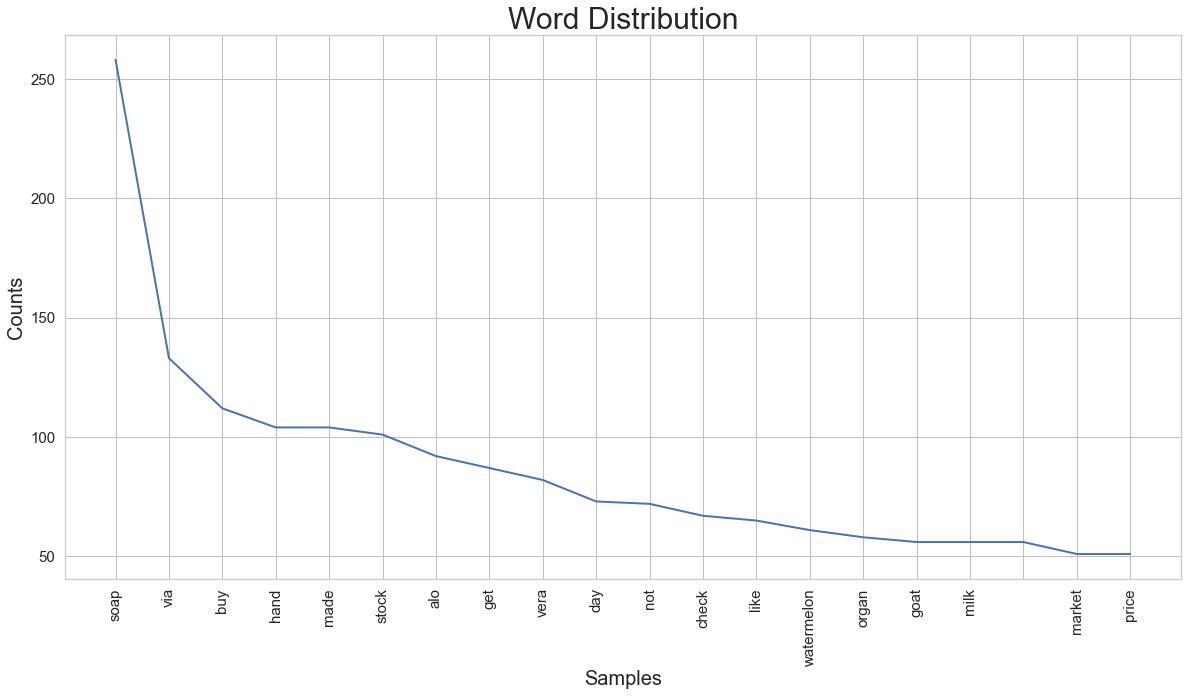

<AxesSubplot:title={'center':'Word Distribution'}, xlabel='Samples', ylabel='Counts'>

In [117]:
plt.figure(figsize=(20,10))
# Annotation
plt.xlabel('Words', fontsize=20)
plt.ylabel('Counts', fontsize = 20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15,rotation=90)
plt.title('Word Distribution', fontsize=30)
wordcountset.plot(20)

In [ ]:
# word cloud
wc = WordCloud(background_color='white', max_words=100, stopwords = STOPWORDS)

# Generate and plot wordcloud
plt.figure(figsize=(20,10))
plt.imshow(wc.generate(wordpool3))
plt.axis('off')
plt.show()

In [119]:
# load spacy large
nlp = spacy.load('en_core_web_lg')

# list # obtain word pool of unique tweets
nerpool = list(master_df8.split_text)
# string - joiin each sentence
nerpool2 = ';'.join(nerpool)
doc_q = nlp(nerpool2)

# spacy NER visualization
displacy.render(doc_q, style='ent', jupyter=True)

## Part 2 - Load Model and Sentiment Analysis

In [3]:
# # prepare to load model
# master_df9 = master_df8

# # reassign text
# master_df9.text = master_df8.split_text

# # save csv
# master_df9.to_csv('data_tweets/tweet_df2.csv')

#load csv
master_df9= pd.read_csv('data_tweets/tweet_df2.csv',index_col=0)
master_df9.head(2)


,text,time,location,source,like_count,quote_count,reply_count,retweet_count,lang,split_text
0,mention last day via,2022-05-01,NaN,topstonks,0,0,0,0,en,mention last day via
1,new investor tri understand stock market,2022-05-01,"St Paul, MN",Twitter for iPhone,0,0,0,0,en,new investor tri understand stock market


In [4]:
# nltk sentiment analysis, since nltk should be top 3
master_df9['siaSent'] = master_df9.text.apply(lambda x : siaSent(x))
# see the output of nltk SIA
master_df9['siaSent'].value_counts()

Neutral     695
Positive    512
Negative    300
Name: siaSent, dtype: int64

In [5]:
master_df9 = master_df9[master_df9.siaSent!='Neutral']

Text(0.5, 1.0, 'Sentiment by Date')

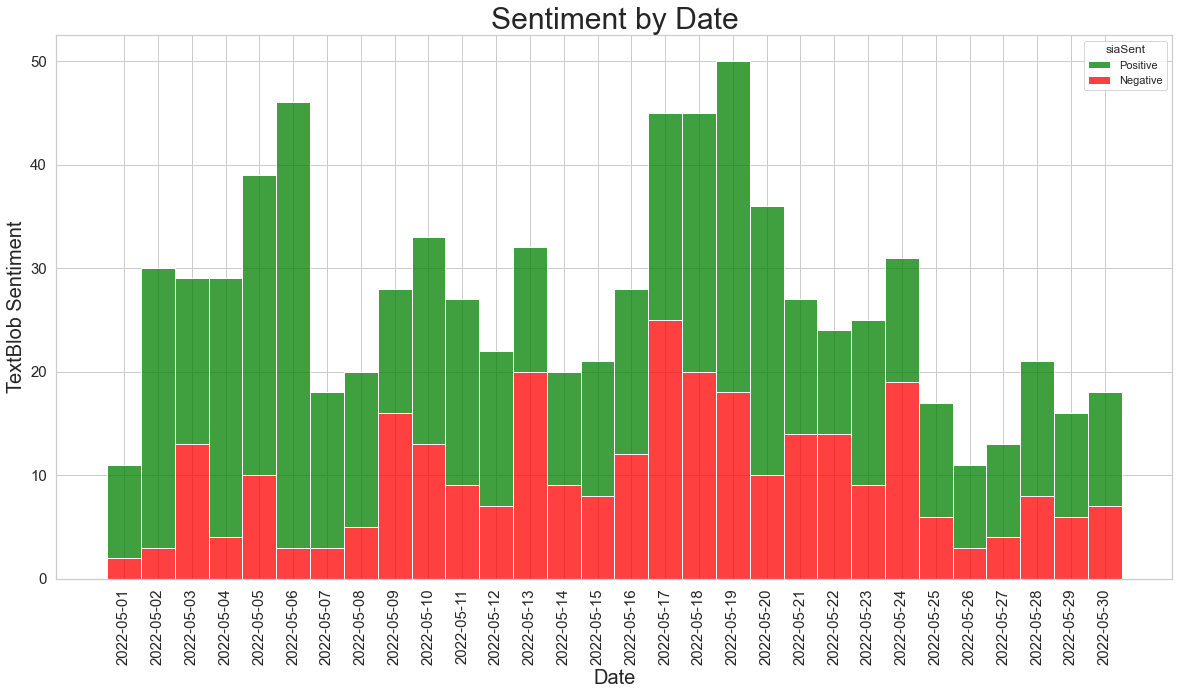

In [11]:
# Histplot stacked by type
plt.figure(figsize=(20,10))
sns.histplot(data=master_df9.sort_values(by='time'),x='time',hue='siaSent',multiple='stack',edgecolor='white',hue_order=['Positive','Negative'],palette=['green','red'])
# Annotation
plt.xlabel('Date', fontsize=20)
plt.ylabel('TextBlob Sentiment', fontsize = 20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15,rotation=90)
plt.title('Sentiment by Date', fontsize=30)

In [6]:
master_df9['listText'] = master_df9.text.apply(lambda x: x.split())
master_df9['len'] = master_df9.listText.apply(len)

master_df9.sort_values('len', ascending=False)

,text,time,location,source,like_count,quote_count,reply_count,retweet_count,lang,split_text,siaSent,listText,len
70,give soap make switch soap hand made soap flip...,2022-05-02,USA,Twitter Web App,2,0,1,0,en,give soap make switch soap hand made soap flip...,Positive,"[give, soap, make, switch, soap, hand, made, s...",15
48,wing make switch soap hand made soap flipper d...,2022-05-02,USA,Twitter Web App,1,1,0,1,en,wing make switch soap hand made soap flipper d...,Positive,"[wing, make, switch, soap, hand, made, soap, f...",14
166,organ make switch soap hand made soap flipper ...,2022-05-03,USA,Twitter Web App,0,1,1,0,en,organ make switch soap hand made soap flipper ...,Positive,"[organ, make, switch, soap, hand, made, soap, ...",14
792,koala hand made organ soap watermelon goat mil...,2022-05-12,USA,Twitter Web App,0,0,1,0,en,koala hand made organ soap watermelon goat mil...,Positive,"[koala, hand, made, organ, soap, watermelon, g...",14
793,koala hand made organ soap watermelon goat mil...,2022-05-12,USA,Twitter Web App,0,0,0,0,en,koala hand made organ soap watermelon goat mil...,Positive,"[koala, hand, made, organ, soap, watermelon, g...",14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1730,fun,2022-05-23,photic zone,Twitter Web App,1,0,0,0,en,fun,Positive,[fun],1
1171,fool,2022-05-17,NaN,Twitter for iPad,0,0,0,0,en,fool,Negative,[fool],1
817,play,2022-05-12,$AMC,Twitter for iPhone,2,0,0,0,en,play,Positive,[play],1
91,doomsday,2022-05-02,🏪Blockchain City,Twitter for Android,0,0,0,0,en,doomsday,Negative,[doomsday],1


In [15]:
group_df = master_df9
group_df.groupby(['time','siaSent'],axis=0).count()


text  location  source  like_count  quote_count  \
time       siaSent                                                     
2022-05-01 Negative     2         2       2           2            2   
           Positive     9         8       9           9            9   
2022-05-02 Negative     3         3       3           3            3   
           Positive    27        18      27          27           27   
2022-05-03 Negative    13         6      13          13           13   
           Positive    16        11      16          16           16   
2022-05-04 Negative     4         4       4           4            4   
           Positive    25        21      25          25           25   
2022-05-05 Negative    10         7      10          10           10   
           Positive    29        21      29          29           29   
2022-05-06 Negative     3         2       3           3            3   
           Positive    43        39      43          43           43   
2022-05-07 Negative     3         3       3           3            3   
           Positive    15        13      15          15           15   
2022-05-08 Negative     5         5       5           5            5   
           Positive    15        11      15          15           15   
2022-05-09 Negative    16        11      16          16           16   
           Positive    12        11      12          12           12   
2022-05-10 Negative    13        11      13          13           13   
           Positive    20        17      20          20           20   
2022-05-11 Negative     9         7       9           9            9   
           Positive    18        13      18          18           18   
2022-05-12 Negative     7         4       7           7            7   
           Positive    15        10      15          15           15   
2022-05-13 Negative    20        11      20          20           20   
           Positive    12         9      12          12           12   
2022-05-14 Negative     9         6       9           9            9   
           Positive    11         2      11          11           11   
2022-05-15 Negative     8         6       8           8            8   
           Positive    13        10      13          13           13   
2022-05-16 Negative    12        11      12          12           12   
           Positive    16        13      16          16           16   
2022-05-17 Negative    25        15      25          25           25   
           Positive    20        10      20          20           20   
2022-05-18 Negative    20         8      20          20           20   
           Positive    25        15      25          25           25   
2022-05-19 Negative    18        13      18          18           18   
           Positive    32        22      32          32           32   
2022-05-20 Negative    10         7      10          10           10   
           Positive    26         9      26          26           26   
2022-05-21 Negative    14         6      14          14           14   
           Positive    13         7      13          13           13   
2022-05-22 Negative    14         8      14          14           14   
           Positive    10         7      10          10           10   
2022-05-23 Negative     9         6       9           9            9   
           Positive    16        11      16          16           16   
2022-05-24 Negative    19        12      19          19           19   
           Positive    12        10      12          12           12   
2022-05-25 Negative     6         3       6           6            6   
           Positive    11         9      11          11           11   
2022-05-26 Negative     3         3       3           3            3   
           Positive     8         6       8           8            8   
2022-05-27 Negative     4         3       4           4            4   
           Positive     9         7       9           9      

### Load Model

In [31]:
# load model
model = load_model('output/gruTF.h5') # max length 15

# load tokenizer
with open('output/token_model1.pickle', 'rb') as handle:
    token = pickle.load(handle)

In [32]:
# predict sentiment using our own model from 2_model.ipynb
master_df9['predict_sent'] = master_df9.listText.apply(lambda x: predictFunc(x))

In [33]:
# certain data does not work, so it returns string "NoWork", we exclude them
master_df10 = master_df9[master_df9.predict_sent!='NoWork']
master_df10.predict_sent.value_counts()

Neutral     665
Positive    115
Negative     32
Name: predict_sent, dtype: int64

In [34]:
# convert sentiment to score 
master_df10['predict_score'] = master_df10['predict_sent'].map({'Negative': -1, 'Neutral': 0, 'Positive':1})

In [35]:
# assign to new df and exclude neutral
master_df11 = master_df10[master_df10.predict_sent!='Neutral']

Text(0.5, 1.0, 'TWTR Sentiment by Date')

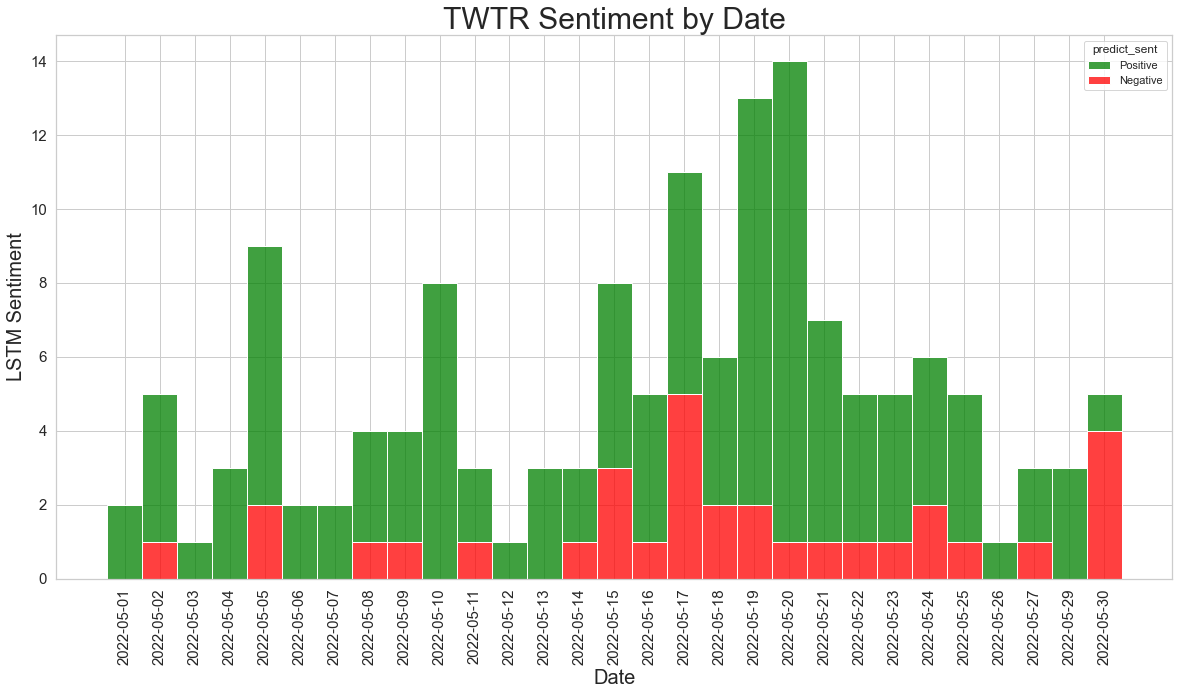

In [36]:
# Histplot stacked by type
plt.figure(figsize=(20,10))
sns.histplot(data=master_df11.sort_values(by='time'),x='time',hue='predict_sent',multiple='stack',edgecolor='white',hue_order=['Positive','Negative'],palette=['green','red'])
# Annotation
plt.xlabel('Date', fontsize=20)
plt.ylabel('LSTM Sentiment', fontsize = 20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15,rotation=90)
plt.title('TWTR Sentiment by Date', fontsize=30)

Text(0.5, 1.0, 'Sentiment by Date')

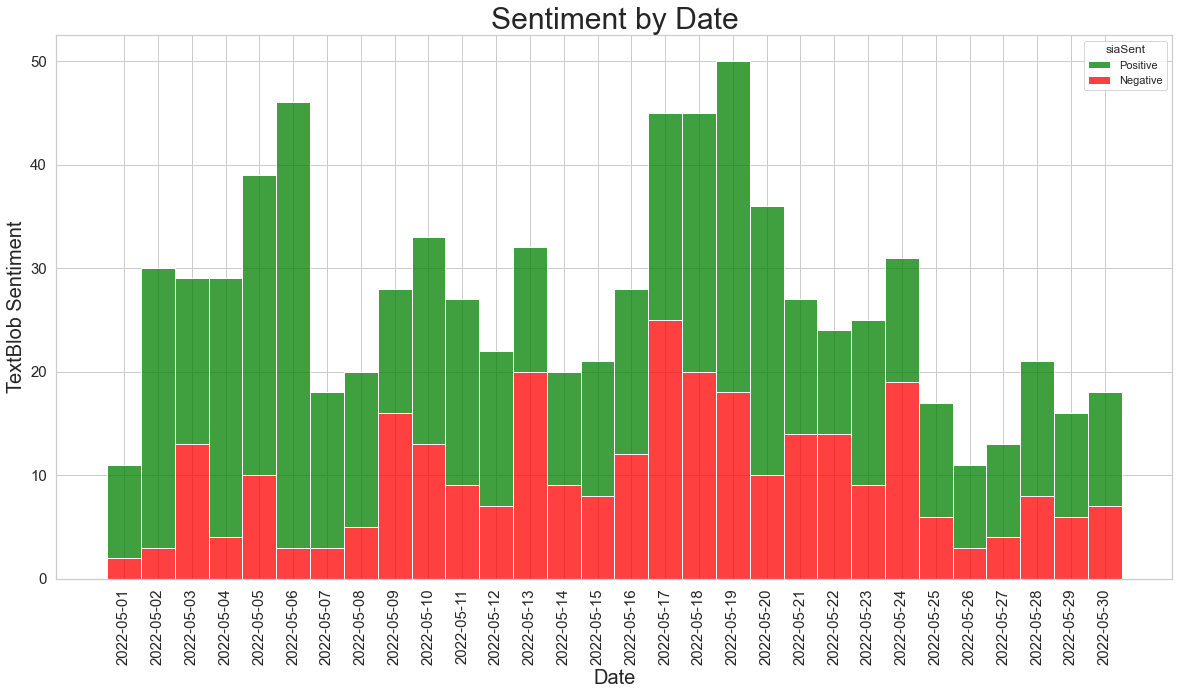

In [37]:
# Histplot stacked by type
plt.figure(figsize=(20,10))
sns.histplot(data=master_df9.sort_values(by='time'),x='time',hue='siaSent',multiple='stack',edgecolor='white',hue_order=['Positive','Negative'],palette=['green','red'])
# Annotation
plt.xlabel('Date', fontsize=20)
plt.ylabel('TextBlob Sentiment', fontsize = 20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15,rotation=90)
plt.title('Sentiment by Date', fontsize=30)

Stock DF

In [154]:
# load stock data
stock_df = pd.read_csv('data_stock/TWTRstockPrice.csv')

In [165]:
# rename columns and assign new df
stock_df1= stock_df
stock_df1 = stock_df.rename(columns={'date':'time','4. close': 'close', '5. volume': 'volume'})
stock_df1.head(3)

,time,1. open,2. high,3. low,close,volume
0,2022-05-31,40.07,40.3500,39.42,39.60,11154668.0
1,2022-05-27,39.57,40.7700,39.48,40.17,16789855.0
2,2022-05-26,38.52,39.5899,38.23,39.52,22968398.0


In [211]:
# merge with tweet counts for visulization
stocktweet_df = pd.merge(stock_df1,count_df, on='time',how='left')

# sort by time
stocktweet_df2 = stocktweet_df.iloc[:25,:].sort_values('time')
stocktweet_df2.head(3)


,time,1. open,2. high,3. low,close,volume,retweet_count,like_count,tweet_count
24,2022-04-26,51.57,51.620,49.43,49.68,114215627.0,NaN,NaN,NaN
23,2022-04-27,49.06,49.260,47.82,48.64,59106880.0,NaN,NaN,NaN
22,2022-04-28,49.01,49.915,47.96,49.11,43816868.0,NaN,NaN,NaN


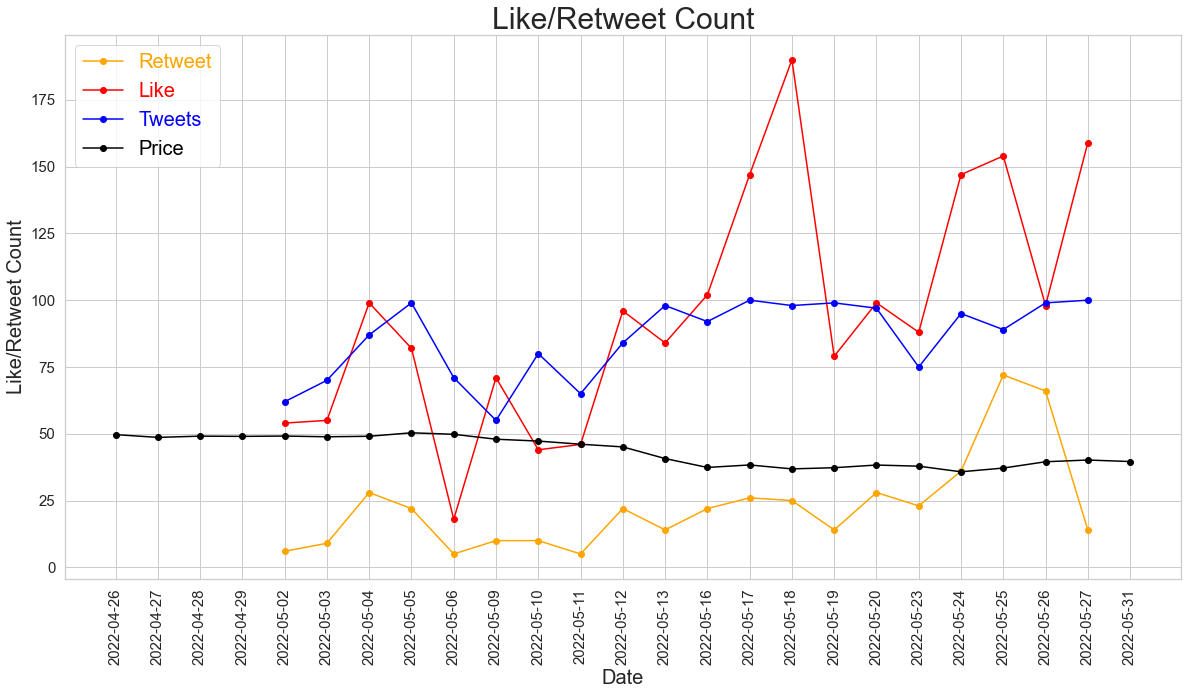

In [213]:
# plot previous chart with stock prices
plt.figure(figsize=(20,10))

plt.plot(stocktweet_df2.time, stocktweet_df2.retweet_count, 'o-', label="Retweet", color='orange')
plt.plot(stocktweet_df2.time, stocktweet_df2.like_count, 'o-', label="Like", color='red')
plt.plot(stocktweet_df2.time, stocktweet_df2.tweet_count, 'o-', label="Tweets", color='blue')
plt.plot(stocktweet_df2.time, stocktweet_df2.close, 'o-', label="Price", color='black')

plt.xlabel('Date', fontsize=20)
plt.ylabel('Like/Retweet Count', fontsize = 20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15,rotation=90)
plt.title('Like/Retweet Count', fontsize=30)
plt.legend(labels=['Retweet','Like','Tweets','Price'],labelcolor=['orange','red','blue','black'],loc="upper left", prop={'size': 20})

## Conclusion

Model: GRU extremely outperformed all other models. Optimizers: SGD works better on Conv1D Bi-LSTM. Adam works a lot better in GRU. <br>

